<a href="https://colab.research.google.com/github/matsunori39/How-Deep-Learning-AI-Works/blob/main/How_Deep_Learning_AI_Works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://info.nikkeibp.co.jp/media/NSW/atcl/books/111100050/

# Chapter 7: Making Sense of Image Recognition AI Code

## 7-2 Prepare training and test data

### Import required modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### Loading training and test data

In [2]:
# image transformation process
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training data
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

# Load test data
testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=2)

# Define class label names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Random display of training data images and labels

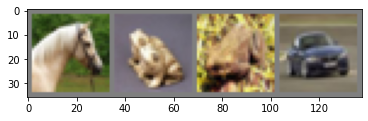

horse  frog  frog   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 7-3 Write code to implement CNN

### Implement CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  # Define each layer
  def __init__(self):
      super(Net, self).__init__()

      # Convolutional layer 1
      self.conv1 = nn.Conv2d(3, 6, 5)

      # Pooling layer
      self.pool = nn.MaxPool2d(2, 2)

      # Convolutional layer 2
      self.conv2 = nn.Conv2d(6, 16, 5)

      # Fully-Connected layer
      self.fc1 = nn.Linear(16 * 5 * 5, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84,10)
  
  # Define configuration
  def forward(self, x):
    # conv1 and pool
    x = self.pool(F.relu(self.conv1(x)))

    # conv2 and pool
    x = self.pool(F.relu(self.conv2(x)))

    # Sort for fc
    x = x.view(-1, 16 * 5 * 5)

    # fc1
    x = F.relu(self.fc1(x))

    # fc2
    x = F.relu(self.fc2(x))

    # fc3 to output layer
    x = self.fc3(x)
    return x


# Generate CNN
net = Net()

### Define loss functions and optimizers

In [5]:
import torch.optim as optim

# The loss function is a cross-entropy function
criterion = nn.CrossEntropyLoss()

# SGD for optimization
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

## 7-4 Code to learn

In [21]:
# 2 Epoch Learning
for epoch in range(2):
  running_loss = 0.0

  # Learning as many data sets as there are data sets
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    # Inference with images of training data
    outputs = net(inputs)

    # Losses are determined by the loss function
    loss = criterion(outputs, labels)

    # Find the gradient by back propagation
    loss.backward()

    # Update parameters
    optimizer.step()

    # Calculate and output loss averages for each 2000 mini-batch
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.898
[1,  6000] loss: 1.694
[1,  8000] loss: 1.583
[1, 10000] loss: 1.498
[1, 12000] loss: 1.459
[2,  2000] loss: 1.398
[2,  4000] loss: 1.372
[2,  6000] loss: 1.340
[2,  8000] loss: 1.307
[2, 10000] loss: 1.297
[2, 12000] loss: 1.292
Finished Training


## 7-5 Let's classify images with test data

### Display images and labels of the top test data

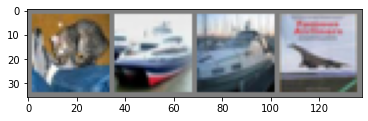

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Classify test data at the top

In [23]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


### Classify the second and subsequent test data

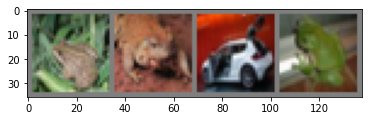

GroundTruth:   frog  frog   car  frog
Predicted:   deer  frog truck  frog


In [24]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

### Find the percentage of correct answers for all test data

In [25]:
correct = 0
total = 0

with torch.no_grad():
  # Classify all test data in order
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    # Counting test data and number of correct answers
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Find and output the percentage of correct answers
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


### Find the percentage of correct answers per class

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  # Classify all test data in order
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    # Count the number of correct answers per class
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

# Find and output the percentage of correct answers per class
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 62 %
Accuracy of  bird : 39 %
Accuracy of   cat : 59 %
Accuracy of  deer : 26 %
Accuracy of   dog : 31 %
Accuracy of  frog : 54 %
Accuracy of horse : 61 %
Accuracy of  ship : 78 %
Accuracy of truck : 60 %


## 7-6 With GPUs, learnig time is much shorter

### Check if GPU has been enabled

In [6]:
print(torch.cuda.is_available())

True


### Generate the objects needed to use the GPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Enabling GPUs in CNN

In [8]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Learning is handled by GPU

In [9]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # inputs, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.240
[1,  4000] loss: 1.948
[1,  6000] loss: 1.719
[1,  8000] loss: 1.603
[1, 10000] loss: 1.524
[1, 12000] loss: 1.466
[2,  2000] loss: 1.406
[2,  4000] loss: 1.348
[2,  6000] loss: 1.357
[2,  8000] loss: 1.320
[2, 10000] loss: 1.290
[2, 12000] loss: 1.263
Finished Training


### Classification is also done on the GPU

In [11]:
# outputs = net(images)
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


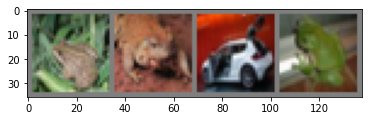

GroundTruth:   frog  frog   car  frog
Predicted:   frog  frog   car  frog


In [12]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# outputs = net(images)
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [13]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    # images, labels = data
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    # images, labels = data
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 80 %
Accuracy of  bird : 30 %
Accuracy of   cat : 30 %
Accuracy of  deer : 53 %
Accuracy of   dog : 53 %
Accuracy of  frog : 65 %
Accuracy of horse : 54 %
Accuracy of  ship : 73 %
Accuracy of truck : 60 %
